In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import copy

# 读入训练数据集和测试数据集
train = pd.read_csv('horseColicTraining.txt', delimiter='\t', header=None)
test = pd.read_csv('horseColicTest.txt', delimiter='\t', header=None)
# 划分特征和标签
X_train, y_train = train.iloc[:, :21].to_numpy(), train.iloc[:, 21].to_numpy()
X_test, y_test = test.iloc[:, :21].to_numpy(), test.iloc[:, 21].to_numpy()
# 将标签为0的样本改为-1
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(299, 21)
(299,)
(67, 21)
(67,)


In [8]:
class AdaBoostClassifier:
    def __init__(self, n_estimators=20, base_clf=DecisionTreeClassifier(max_depth=2)):
        """
        :param n_estimators: 基分类器个数
        :param base_clf: 基分类器种类
        """
        self.n_estimators = n_estimators
        self.alphas = []
        self.classifiers = []
        self.base_clf = base_clf

    def fit(self, X_train, y_train):
        m, n = X_train.shape
        w = np.ones(m) / m  # 归一化

        for i in range(self.n_estimators):
            base_classifier = copy.deepcopy(self.base_clf)
            base_classifier.fit(X_train, y_train, sample_weight=w)  # 用特定的权重进行训练
            y_pred = base_classifier.predict(X_train)  # 预测训练样本

            error_o = y_pred != y_train  # 计算错误率
            error = np.sum(w * error_o)  # 计算加权后的错误率
            print('base_clf_%02d train acc: %.4f'%(i + 1, 1 - np.sum(error_o) / len(X_train)))
            alpha = 0.5 * np.log((1 - error) / error)  # 设置基学习器权重
            w = w * np.exp(-alpha * y_train * y_pred)  # 更新样本比重
            w = w / np.sum(w)  # 归一化样本

            self.alphas.append(alpha)
            self.classifiers.append(base_classifier)

    def predict(self, X_test):
        predictions = np.zeros(X_test.shape[0])

        for alpha, classifier in zip(self.alphas, self.classifiers):
            predictions += alpha * classifier.predict(X_test)  # 求和各学习器加权预测值

        return np.sign(predictions)

In [3]:
ad_boost = AdaBoostClassifier(n_estimators=20, base_clf=DecisionTreeClassifier(max_depth=2, random_state=42))
ad_boost.fit(X_train, y_train)

base_clf_01 train acc: 0.7625
base_clf_02 train acc: 0.7090
base_clf_03 train acc: 0.6589
base_clf_04 train acc: 0.6254
base_clf_05 train acc: 0.5652
base_clf_06 train acc: 0.6455
base_clf_07 train acc: 0.6355
base_clf_08 train acc: 0.4147
base_clf_09 train acc: 0.4950
base_clf_10 train acc: 0.6622
base_clf_11 train acc: 0.6756
base_clf_12 train acc: 0.4448
base_clf_13 train acc: 0.5786
base_clf_14 train acc: 0.7191
base_clf_15 train acc: 0.5786
base_clf_16 train acc: 0.6321
base_clf_17 train acc: 0.6622
base_clf_18 train acc: 0.6221
base_clf_19 train acc: 0.5819
base_clf_20 train acc: 0.4682


In [4]:
## 1) 计算死亡率
y_pred = ad_boost.predict(X_test)
print('Rate of death is: ', np.sum(y_pred == -1) / len(y_pred))

Rate of death is:  0.417910447761194


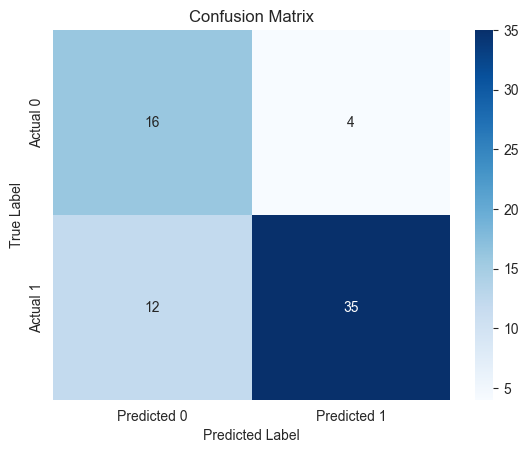

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import seaborn as sns

## 2) 画图输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# 3) 计算查准率、查全率和 F1 度量
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8974
Recall: 0.7447
F1 Score: 0.8140


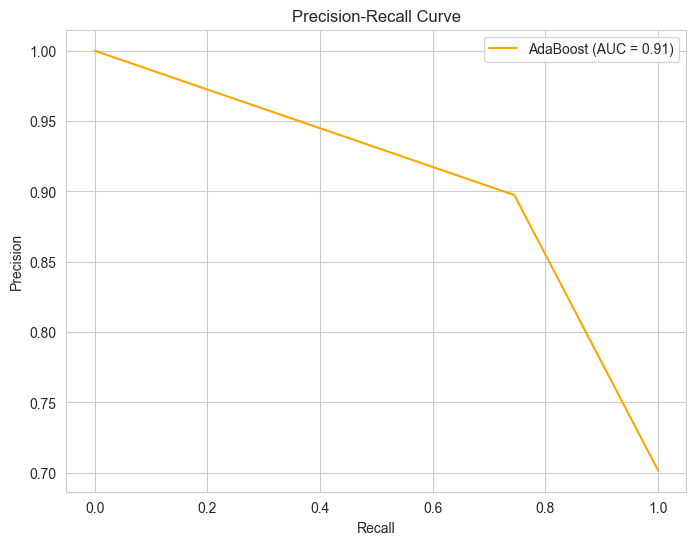

In [7]:
# 4) 绘制 P-R 曲线
precision_curve, recall_curve, _ = precision_recall_curve(y_test, ad_boost.predict(X_test))
area_under_curve = auc(recall_curve, precision_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'AdaBoost (AUC = {area_under_curve:.2f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()